# Late-Gad test
----

In [1]:
%matplotlib inline

import os
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.colors as cpl
import numpy as np
from pconv_keras.pconv_model import PConvUnet

/mnt/data/anaconda3/envs/pconv-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/data/anaconda3/envs/pconv-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/data/anaconda3/envs/pconv-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/data/anaconda3/envs/pconv-keras/lib

In [2]:
case_id = '103'
image_dir = r'/mnt/data/data/MYOPS2020/train25/'
mask_dir = r'/mnt/data/data/MYOPS2020/train25_myops_gd/'

In [3]:
# load the NII image, but it needs to rotate to view the CMR properly
im_de = np.rot90(
    nib.load(
        os.path.join(image_dir, f'myops_training_{case_id}_DE.nii.gz')
    ).get_fdata(),
    k=1,
    axes=(0,1)
)

# cut intensity above 99 percentile
th = np.percentile(im_de, 99)
im_de[im_de>th] = th

print(f"DE image: {im_de.shape} - min:{im_de.min()}, max:{im_de.max()}")

DE image: (471, 483, 3) - min:0.0, max:869.0


In [4]:
# load the NII image, but it needs to rotate to view the CMR properly
im_con = np.rot90(
    nib.load(
        os.path.join(mask_dir, f'myops_training_{case_id}_gd.nii.gz')
    ).get_fdata(),
    k=1,
    axes=(0,1)
)

print(f"CON image: {im_con.shape} - labels:{list(set(im_con.flatten()))}")

CON image: (471, 483, 3) - labels:[0.0, 1220.0, 200.0, 2221.0, 500.0, 600.0]


## Plot the original images


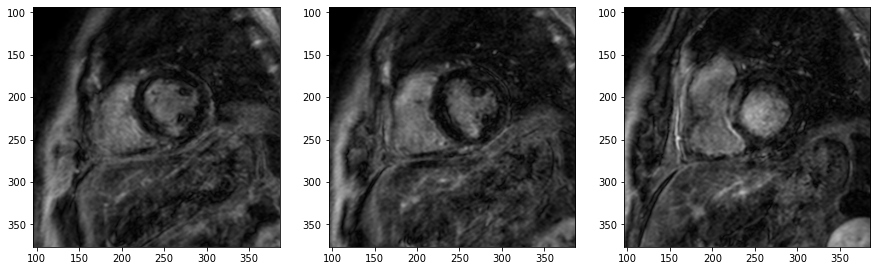

In [5]:
nimgs = im_de.shape[2]
fig, ax = plt.subplots(nrows=1, ncols=nimgs, figsize=(15,5))
for i in range(nimgs):
    ax[i].imshow(im_de[:,:,i], cmap=plt.cm.gray)
    ax[i].margins(-0.2)

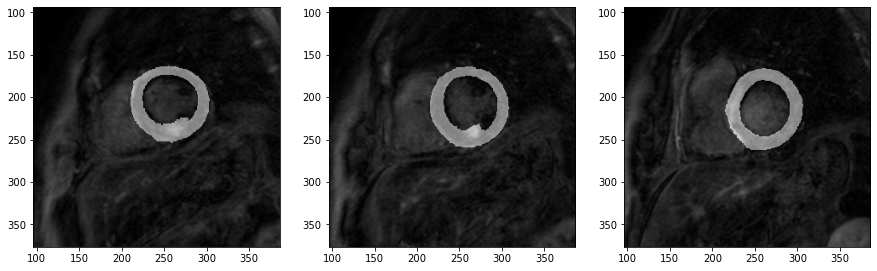

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=nimgs, figsize=(15,5), frameon=False)
for i in range(nimgs):
    ax[i].imshow(im_de[:,:,i], cmap=plt.cm.gray)
    ax[i].imshow((im_con[:,:,i]==1220) + (im_con[:,:,i]==200) + (im_con[:,:,i]==2221), cmap=plt.cm.gray, alpha=0.5)
    ax[i].margins(-0.2)

## Crop to 256x256

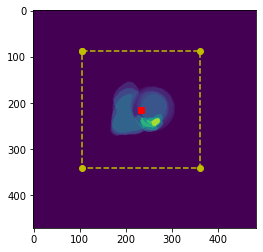

In [7]:
im_sum = im_con.sum(axis=2)
ctr = np.array([m.mean() for m in np.where(im_sum > 0)])
bb0 = (ctr - 128).astype(np.int)

plt.imshow(im_sum)
plt.plot(ctr[1], ctr[0], 'rs')
plt.plot(
    [bb0[1], bb0[1]+255, bb0[1]+255, bb0[1], bb0[1]], 
    [bb0[0], bb0[0], bb0[0]+255, bb0[0]+255, bb0[0]], 
    'yo', linestyle='--')

In [8]:
im_de_crop = im_de[bb0[0]:(bb0[0]+256), bb0[1]:(bb0[1]+256), :]
im_con_crop = im_con[bb0[0]:(bb0[0]+256), bb0[1]:(bb0[1]+256), :]
print(f"Cropped image:{im_de_crop.shape}, masked:{im_con_crop.shape}")

Cropped image:(256, 256, 3), masked:(256, 256, 3)


## Create 256x256x3 image, masked & mask

I need to create masked, mask and ori. All of them in 256x256x3. Then call predict with `model.predict([masked, mask])`.

### ORI

In [9]:
# create 3 dimension
ori = np.moveaxis(np.tile(im_de_crop, (3,1,1,1)), [0, -1], [-1, 0])
print(ori.shape)

# normalize per image
for i in range(ori.shape[0]):
    ori[i,:,:,:] /= ori[i,:,:,:].max()

(3, 256, 256, 3)


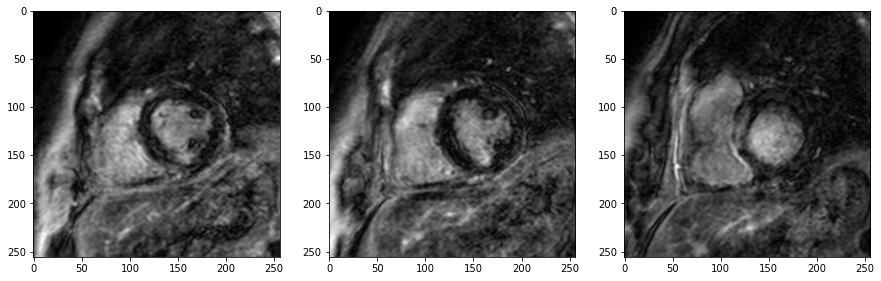

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=ori.shape[0], figsize=(15,5))
for i in range(ori.shape[0]):
    ax[i].imshow(ori[i,:,:,:])

### MASK

In [19]:
im_con_sel = (im_con_crop==1220) + (im_con_crop==2221)
im_con_sel.shape

(256, 256, 3)

In [20]:
# create 3 dimension
mask = np.moveaxis(np.tile(im_con_sel==0, (3,1,1,1)), [0, -1], [-1, 0]).astype(np.int)
print(f"mask:{mask.shape}, label:{list(set(mask.flatten()))}")

mask:(3, 256, 256, 3), label:[0, 1]


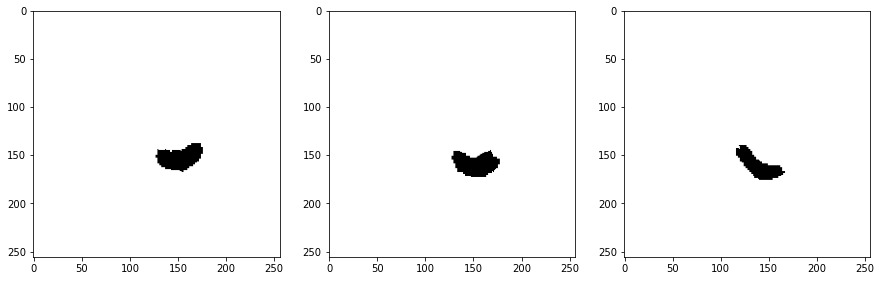

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=ori.shape[0], figsize=(15,5))
for i in range(mask.shape[0]):
    ax[i].imshow(mask[i,:,:,:] * 255)

### MASKED

In [22]:
# create masked images
masked = ori.copy()
masked[mask == 0] = 1
masked.shape

(3, 256, 256, 3)

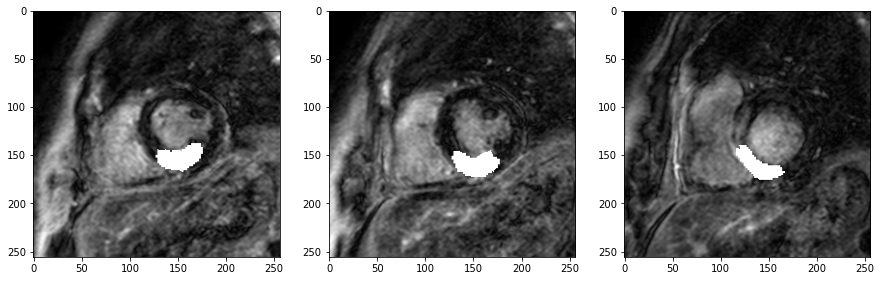

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=ori.shape[0], figsize=(15,5))
for i in range(masked.shape[0]):
    ax[i].imshow(masked[i,:,:,:])

## Predict

In [16]:
model = PConvUnet(img_rows=256, img_cols=256,
                   vgg_weights=r"/mnt/data/train_camp/pconv_keras_imagenet/pytorch_to_keras_vgg16.h5")
model.load(
    r"/mnt/data/train_camp/pconv_keras_celeba/imagenet_phase2/weights.08-1.12.h5",
    train_bn=False,
    lr=0.00005
)

In [24]:
y = model.predict([masked, mask])

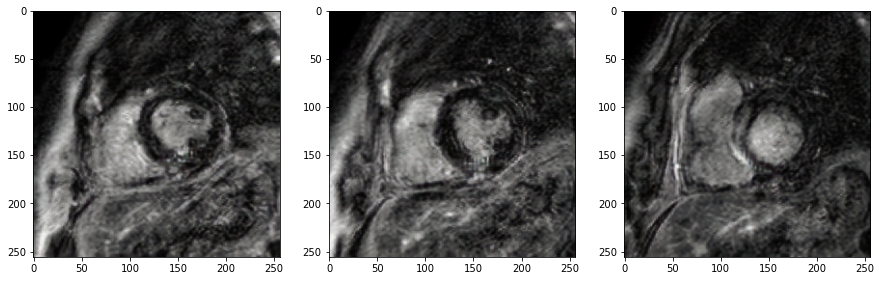

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=ori.shape[0], figsize=(15,5))
for i in range(y.shape[0]):
    ax[i].imshow(y[i,:,:,:])